# This is an example SARIMA Forecast, and all data has been anonymized and modified 

### In this forecast we are forecasting a metric called Customer Dollar Retention. 

#### The formula is (Beginning of the month value - cancellation $ for that month) / Beginning of the month value 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima


# Loading the Data

In [2]:
df = pd.read_csv("Monthly_C$R.csv")
df['Month'] = pd.to_datetime(df.Month)
df['C$R'] = df['C$R'].str.rstrip('%').astype('float') 
df.index = df.Month

# Ensure the frequency is set, e.g., 'MS' for month start if it's monthly data
# This is crucial for ARIMA models as they are sensitive to the frequency of the data
df = df.asfreq('MS')
# df = df.drop('BOMMRR', axis=1)
# df = df.drop('EOMMRR', axis=1)

df.head(5) 


/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_45886/1811174876.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month'] = pd.to_datetime(df.Month)


,Month,C$R
Month,,
2017-02-01,2017-02-01,83.63
2017-03-01,2017-03-01,83.54
2017-04-01,2017-04-01,85.13
2017-05-01,2017-05-01,84.24
2017-06-01,2017-06-01,84.14


# Exploratory Stats

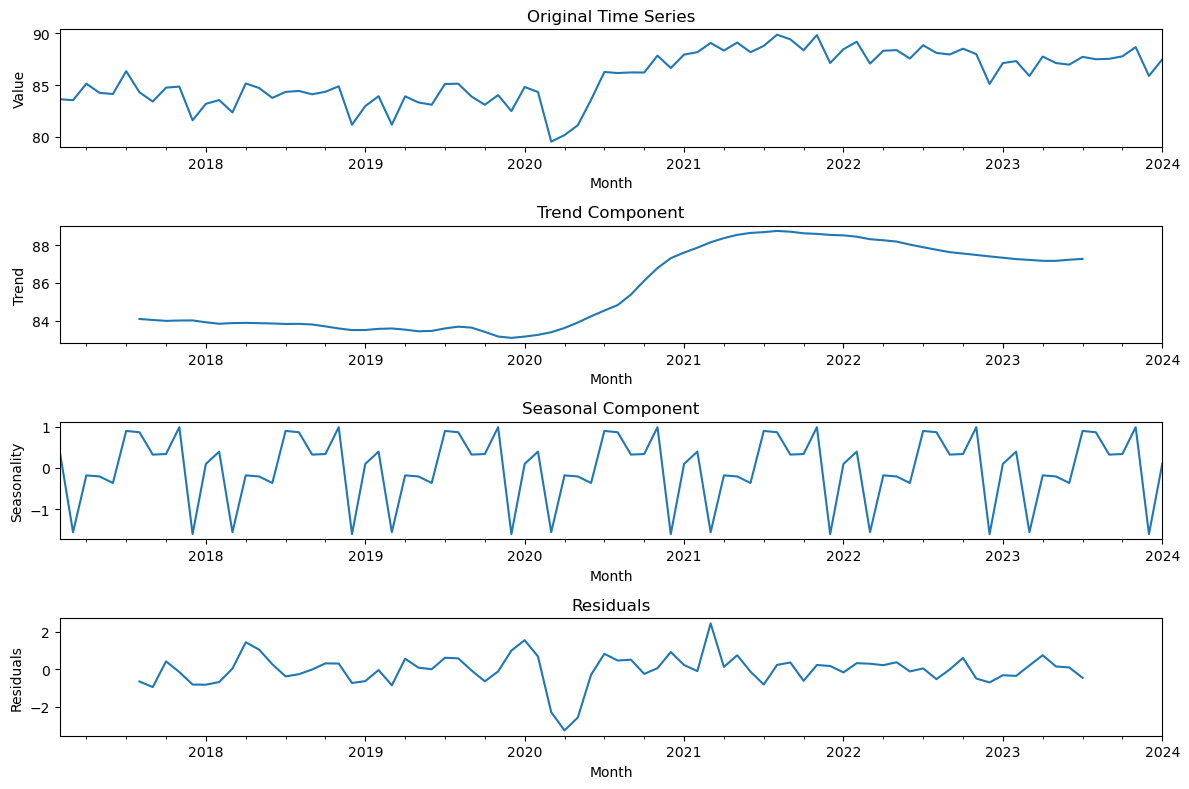

In [3]:

decomposition = seasonal_decompose(df['C$R'], model='additive')
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
df['C$R'].plot(ax=ax1, title='Original Time Series')
ax1.set_ylabel('Value')
decomposition.trend.plot(ax=ax2, title='Trend Component')
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal Component')
ax3.set_ylabel('Seasonality')
decomposition.resid.plot(ax=ax4, title='Residuals')
ax4.set_ylabel('Residuals')
plt.tight_layout()

In [4]:
# Perform KPSS test
result_adf_stock = kpss(df['C$R'], nlags="auto")
#result_adf_hr = kpss(hr, nlags="auto")


print(f'KPSS Statistic: {result_adf_stock[0]}')
print(f'p-value: {result_adf_stock[1]}')
print('Critical Values:')
for key, value in result_adf_stock[3].items():
    print(f'\t{key}: {value}')
    
#print("---------------------------")

#print(f'KPSS Statistic: {result_adf_hr[0]}')
#print(f'p-value: {result_adf_hr[1]}')
print('Critical Values:')
#for key, value in result_adf_hr[3].items():
    #print(f'\t{key}: {value}')

KPSS Statistic: 0.9766736346166529
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Critical Values:


/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_45886/2709460540.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_adf_stock = kpss(df['C$R'], nlags="auto")


In [5]:
##Low P value means non stationary, so we need to difference this data

In [6]:
missing_values = df.isna().sum()

print(missing_values)

Month    0
C$R      0
dtype: int64


In [7]:
def test_stationarity(timeseries):
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform the test on the 'C$R' column
test_stationarity(df['C$R'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.174389
p-value                         0.684515
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [8]:
'''Understanding the Results of Fuller Teest
Test Statistic: A more negative value suggests a stronger rejection of the null hypothesis (that the series is non-stationary).
p-value: If the p-value is less than a threshold (e.g., 5%), it suggests that the series is stationary.
Critical Values: The series is considered stationary if the Test Statistic is less than the Critical Value.'''

'Understanding the Results of Fuller Teest\nTest Statistic: A more negative value suggests a stronger rejection of the null hypothesis (that the series is non-stationary).\np-value: If the p-value is less than a threshold (e.g., 5%), it suggests that the series is stationary.\nCritical Values: The series is considered stationary if the Test Statistic is less than the Critical Value.'

In [9]:
'''ADF test with the high p values means data not stationary ---this is also what our KPSS test says'''

'ADF test with the high p values means data not stationary ---this is also what our KPSS test says'

In [10]:
'''Seasonal Decomposition:
This breaks down the time series into trend, seasonality, and residuals. If you observe a repeating pattern in the seasonal
component, it suggests seasonality in your data.

Dickey-Fuller Test: 
This tests the null hypothesis that a unit root is present in time series sample.
If the p-value is low (commonly <0.05) and the Test Statistic is less than the Critical Values, it suggests stationarity.
If you find seasonality or non-stationarity, you may need to transform your data (e.g., differencing, log transformation) 
before fitting an ARIMA or SARIMA model.'''

'Seasonal Decomposition:\nThis breaks down the time series into trend, seasonality, and residuals. If you observe a repeating pattern in the seasonal\ncomponent, it suggests seasonality in your data.\n\nDickey-Fuller Test: \nThis tests the null hypothesis that a unit root is present in time series sample.\nIf the p-value is low (commonly <0.05) and the Test Statistic is less than the Critical Values, it suggests stationarity.\nIf you find seasonality or non-stationarity, you may need to transform your data (e.g., differencing, log transformation) \nbefore fitting an ARIMA or SARIMA model.'

In [11]:
# Check for missing values in 'C$R' column
if df['C$R'].isna().any():
    print("The 'C$R' column contains missing values. Please handle them before proceeding.")
else:
    # Perform the Ljung-Box test directly on the 'C$R' column
    lags = [12, 24, 36]  # Lags for the test
    lb_result = acorr_ljungbox(df['C$R'], lags=lags)

    # Print the result object to understand its structure
    print("Ljung-Box Test Result:")
    print(lb_result)

Ljung-Box Test Result:
       lb_stat     lb_pvalue
12  401.608502  1.727427e-78
24  457.389546  1.124847e-81
36  499.613045  5.611448e-83


In [12]:
'''What this means in practical terms is that there is very strong evidence of autocorrelation in 
your time series at lags of 12 months,24 months, and 36 months. This could suggest that there is a
yearly pattern that repeats (since the data is monthly and 
the lags are multiples of 12), and this pattern is highly statistically significant.'''

'What this means in practical terms is that there is very strong evidence of autocorrelation in \nyour time series at lags of 12 months,24 months, and 36 months. This could suggest that there is a\nyearly pattern that repeats (since the data is monthly and \nthe lags are multiples of 12), and this pattern is highly statistically significant.'

In [13]:
'''Given the strong evidence of autocorrelation at lags of 12, 24, and 36 months from the Ljung-Box test results, 
it's clear that our time series data exhibits significant seasonal patterns. For modeling such data,
you should consider using models that can capture seasonality. Here are a few options:

Seasonal ARIMA (SARIMA): This model extends ARIMA to include seasonal terms. I
t is specified with the seasonal parameters (P, D, Q)s, where 'P' is the seasonal autoregressive order, 
'D' is the seasonal differencing order, 'Q' is the seasonal moving average order, and 's' is the number of periods in a season. 
Given the evidence of yearly seasonality, 's' would be 12 for monthly data.

SARIMAX: This is an extension of SARIMA that also includes exogenous variables (X),
which are external factors that could affect the time series. If you have relevant external predictors, consider using SARIMAX.'''

"Given the strong evidence of autocorrelation at lags of 12, 24, and 36 months from the Ljung-Box test results, \nit's clear that our time series data exhibits significant seasonal patterns. For modeling such data,\nyou should consider using models that can capture seasonality. Here are a few options:\n\nSeasonal ARIMA (SARIMA): This model extends ARIMA to include seasonal terms. I\nt is specified with the seasonal parameters (P, D, Q)s, where 'P' is the seasonal autoregressive order, \n'D' is the seasonal differencing order, 'Q' is the seasonal moving average order, and 's' is the number of periods in a season. \nGiven the evidence of yearly seasonality, 's' would be 12 for monthly data.\n\nSARIMAX: This is an extension of SARIMA that also includes exogenous variables (X),\nwhich are external factors that could affect the time series. If you have relevant external predictors, consider using SARIMAX."

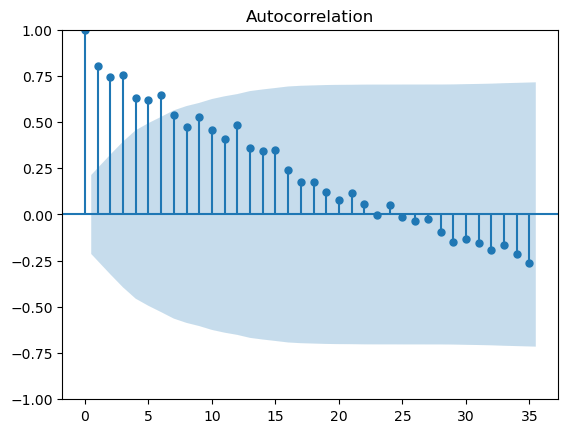

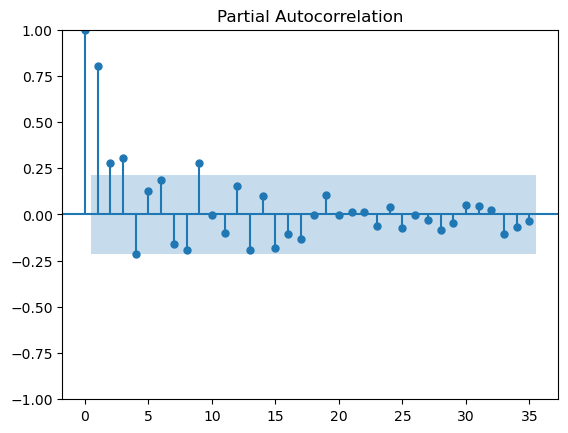

ADF Statistic: -1.1743892324826584
p-value: 0.6845146697007808
Critical Value (1%): -3.526004646825607
Critical Value (5%): -2.9032002348069774
Critical Value (10%): -2.5889948363419957


In [14]:
ts = df['C$R']

# 3. Autocorrelation and Partial Autocorrelation
plot_acf(ts, lags=35)  # adjust lags as needed
plot_pacf(ts, lags=35)  # adjust lags as needed
plt.show()

# 4. Dicky-Fuller Test
result = adfuller(ts.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

In [15]:
##AD-Fuller test: If p-value is small (< 0.05), the series is likely stationary.
#The P value is .49 so we are going to need to difference the data do make it stationary

# Interpretation:
# The non-stationarity suggested by the ADF test is consistent with the ACF plot, 
# which does not show the sharp cutoff typically associated with a stationary series. 
# The PACF plot suggests an AR(1) process may be present, but this would need to be modeled in a 
# differenced series due to the lack of stationarity.

## Apply Differencing

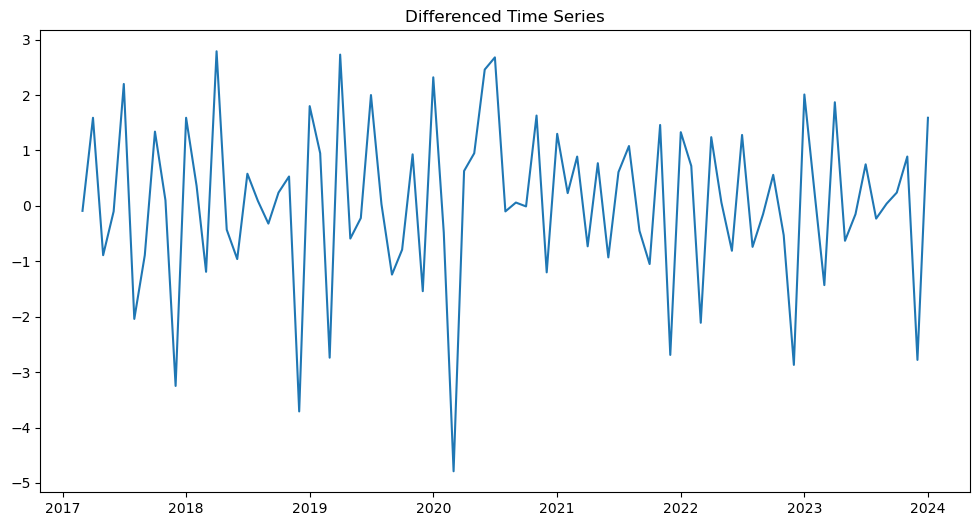

ADF Statistic: -2.6367561394485053
p-value: 0.08563594759051846
Critical Value (1%): -3.526004646825607
Critical Value (5%): -2.9032002348069774
Critical Value (10%): -2.5889948363419957


In [16]:
# Applying differencing
ts_diff = ts - ts.shift(1)
ts_diff.dropna(inplace=True)

# Re-visualize the differenced data
plt.figure(figsize=(12,6))
plt.plot(ts_diff)
plt.title('Differenced Time Series')
plt.show()

# Re-run the Dicky-Fuller test
result_diff = adfuller(ts_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

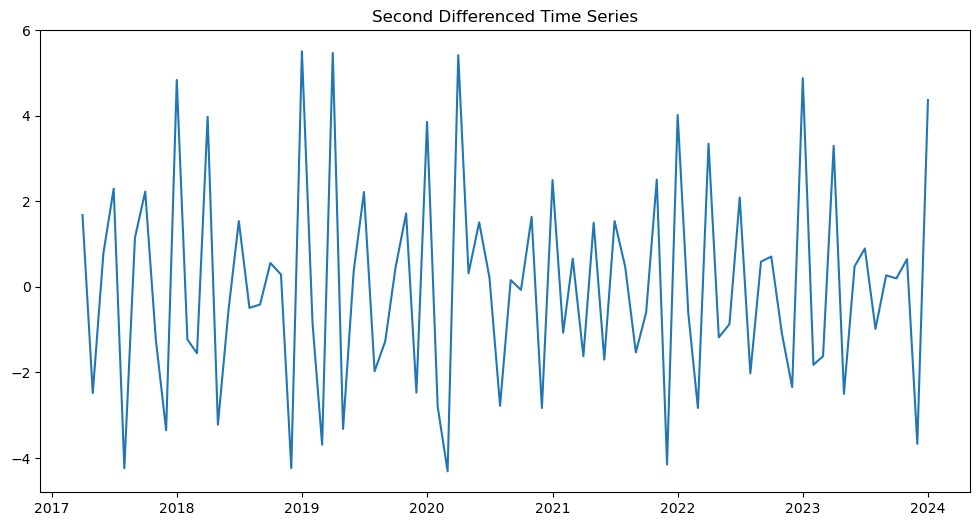

ADF Statistic: -4.5795013472937125
p-value: 0.00014088589950948425
Critical Value (1%): -3.528889992207215
Critical Value (5%): -2.9044395987933362
Critical Value (10%): -2.589655654274312


In [17]:
ts_diff2 = ts_diff - ts_diff.shift(1)
ts_diff2.dropna(inplace=True)

# Re-visualize the differenced data
plt.figure(figsize=(12,6))
plt.plot(ts_diff2)
plt.title('Second Differenced Time Series')
plt.show()

# Re-run the Dicky-Fuller test
result_diff2 = adfuller(ts_diff2)
print('ADF Statistic:', result_diff2[0])
print('p-value:', result_diff2[1])
for key, value in result_diff2[4].items():
    print(f'Critical Value ({key}): {value}')

# Starting with SARIMA

## Global, overall, forecast (not bottom up)

In [18]:
# Run auto_arima
model = auto_arima(df['C$R'], start_p=0, start_q=0,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=333.247, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=242.627, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=334.777, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=250.398, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=236.018, Time=0.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=318.607, Time=0.14 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=237.501, Time=0.25 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=237.233, Time=0.35 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=264.998, Time=0.24 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=237.990, Time=0.46 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=235.51

In [19]:
'''Lower AIC values indicate a better model.'''

'Lower AIC values indicate a better model.'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59196D-01    |proj g|=  2.36282D-01

At iterate    5    f=  9.08055D-01    |proj g|=  9.35501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.149D-05   9.081D-01
  F =  0.90805417537617639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.


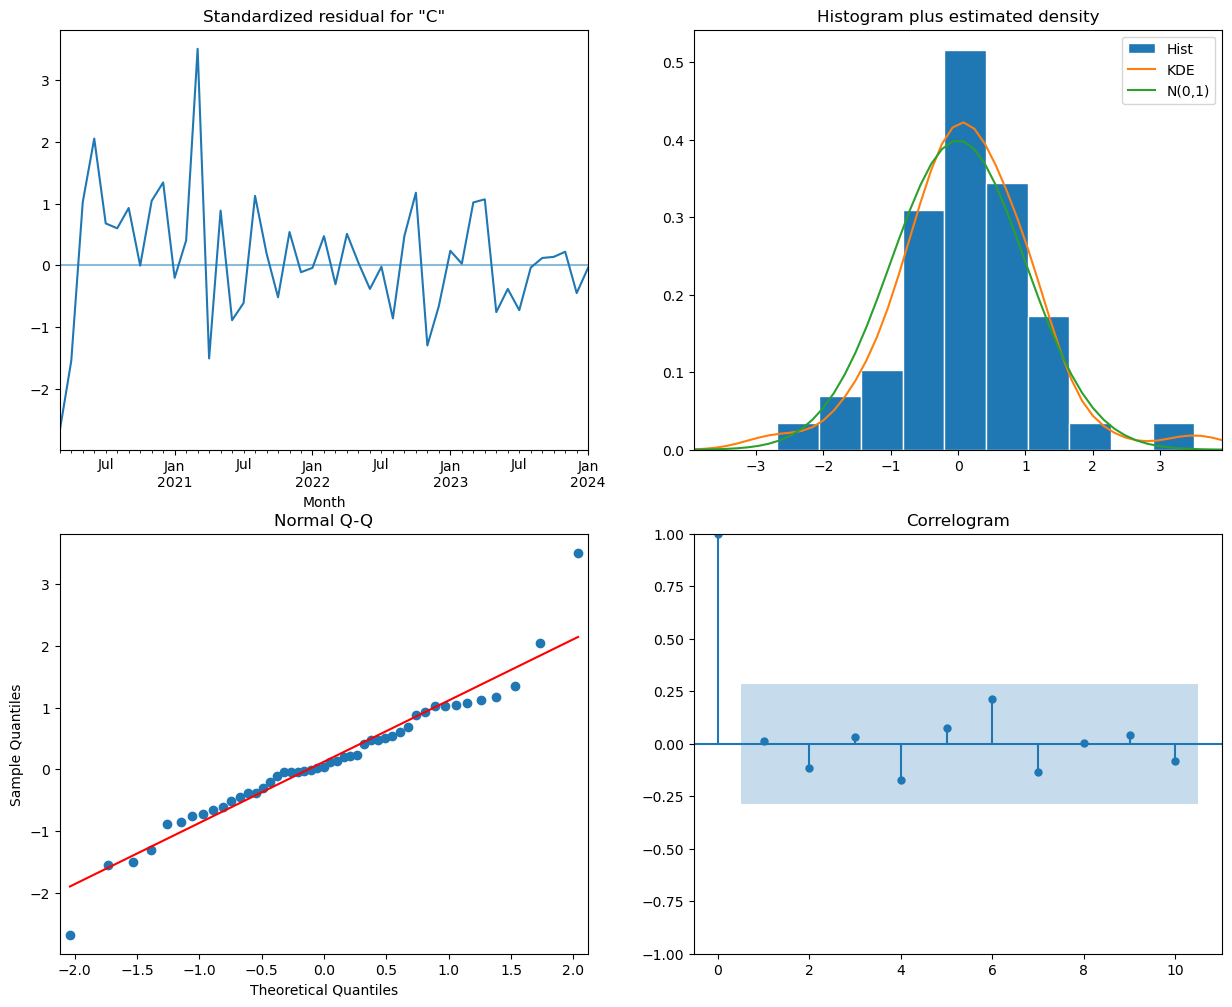

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming you have already preprocessed your dataframe 'df'
# and set 'C$R' as the column of interest with datetime index

# Fit the SARIMA model
model = SARIMAX(df['C$R'],
                order=(1, 0, 0),              # Non-seasonal order
                seasonal_order=(2, 1, 0, 12),  # Seasonal order
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

# Diagnostic plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [21]:
forecast = results.get_forecast(steps=12)
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Display the forecast and confidence intervals
print(predicted_mean)
print(confidence_intervals)

2024-02-01    87.778287
2024-03-01    87.155069
2024-04-01    87.923079
2024-05-01    87.963329
2024-06-01    87.412902
2024-07-01    88.205353
2024-08-01    88.411415
2024-09-01    88.238150
2024-10-01    88.036073
2024-11-01    88.922960
2024-12-01    86.169873
2025-01-01    87.733361
Freq: MS, Name: predicted_mean, dtype: float64
            lower C$R  upper C$R
2024-02-01  85.374883  90.181691
2024-03-01  83.897454  90.412684
2024-04-01  84.094203  91.751955
2024-05-01  83.714884  92.211775
2024-06-01  82.842737  91.983067
2024-07-01  83.382333  93.028373
2024-08-01  83.386492  93.436339
2024-09-01  83.050241  93.426060
2024-10-01  82.715557  93.356589
2024-11-01  83.493923  94.351998
2024-12-01  80.651626  91.688119
2025-01-01  82.141527  93.325195


# BOTTOM UP FORECASTING

## Other Segments: Sku, Geo, Service Model, Emmployee size

In [22]:
df_hub = pd.read_csv("Monthly C$R by Hub.csv")
df_hub.head(5) 


,Report Month,Marketing Hub C$R,Sales Hub C$R,Service Hub C$R,CMS Hub C$R,Ops Hub C$R,Total C$R
0,2024-01,87.7%,87.6%,85.2%,86.6%,87.1%,87.5%
1,2023-12,86.2%,86.7%,83.0%,83.8%,82.9%,85.9%
2,2023-11,89.1%,89.3%,85.4%,86.4%,86.3%,88.7%
3,2023-10,88.8%,86.8%,84.0%,86.5%,86.9%,87.8%
4,2023-09,88.0%,87.5%,85.3%,86.1%,86.3%,87.5%


In [23]:

df_hub['Report Month'] = pd.to_datetime(df_hub['Report Month'])
df_hub['Marketing Hub C$R'] = df_hub['Marketing Hub C$R'].str.rstrip('%').astype('float') 
df_hub['Sales Hub C$R'] = df_hub['Sales Hub C$R'].str.rstrip('%').astype('float') 
df_hub['Service Hub C$R'] = df_hub['Service Hub C$R'].str.rstrip('%').astype('float') 
df_hub['CMS Hub C$R'] = df_hub['CMS Hub C$R'].str.rstrip('%').astype('float') 
df_hub['Ops Hub C$R'] = df_hub['Ops Hub C$R'].str.rstrip('%').astype('float') 
df_hub = df_hub.drop('Total C$R', axis=1)
df_hub.index = df_hub['Report Month']

# Ensure the frequency is set, e.g., 'MS' for month start if it's monthly data
# This is crucial for ARIMA models as they are sensitive to the frequency of the data
df_hub = df_hub.asfreq('MS')


In [24]:
df_hub.head(5) 


,Report Month,Marketing Hub C$R,Sales Hub C$R,Service Hub C$R,CMS Hub C$R,Ops Hub C$R
Report Month,,,,,,
2020-02-01,2020-02-01,85.7,79.8,81.6,82.8,NaN
2020-03-01,2020-03-01,80.5,76.8,72.5,81.1,NaN
2020-04-01,2020-04-01,82.3,74.0,74.0,76.1,NaN
2020-05-01,2020-05-01,82.4,78.9,73.1,74.8,NaN
2020-06-01,2020-06-01,85.2,79.5,76.5,79.7,NaN


In [25]:
# Prepare a dictionary to hold forecasts
forecasts = {}

# List of columns to forecast
columns_to_forecast = ['Marketing Hub C$R', 'Sales Hub C$R', 'Service Hub C$R', 'CMS Hub C$R']

# Loop over the columns and create forecasts
for column in columns_to_forecast:
    # Assuming non-seasonal order of (1, 1, 1) and seasonal order of (1, 1, 1, 12)
    # You can adjust these orders based on the column's data or use auto_arima to find optimal parameters
    sarima_model = auto_arima(df_hub[column], start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=1, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

    # Forecast the next 12 months
    forecast = sarima_model.predict(n_periods=12)
    forecasts[column] = forecast


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=133.702, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=137.992, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=131.337, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=131.742, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=134.798, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=133.192, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=133.191, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=131.869, Time=0.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=135.191, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=131.759, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=133.324, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=133.320, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=131.375, Time=0.02 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=135.281, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12] intercep

In [26]:
# Convert the forecasts to a DataFrame
forecast_df = pd.DataFrame(forecasts, index=pd.date_range(start=df_hub.index[-1] + pd.offsets.MonthBegin(1), periods=12))

# Display the forecast DataFrame
print(forecast_df)

            Marketing Hub C$R  Sales Hub C$R  Service Hub C$R  CMS Hub C$R
2024-02-01          88.112416      87.936424        86.982253    86.522526
2024-02-02                NaN            NaN              NaN          NaN
2024-02-03                NaN            NaN              NaN          NaN
2024-02-04                NaN            NaN              NaN          NaN
2024-02-05                NaN            NaN              NaN          NaN
2024-02-06                NaN            NaN              NaN          NaN
2024-02-07                NaN            NaN              NaN          NaN
2024-02-08                NaN            NaN              NaN          NaN
2024-02-09                NaN            NaN              NaN          NaN
2024-02-10                NaN            NaN              NaN          NaN
2024-02-11                NaN            NaN              NaN          NaN
2024-02-12                NaN            NaN              NaN          NaN


In [27]:
# Print the forecasts for each column
for hub, forecast in forecasts.items():
    print(f"Forecast for {hub}:")
    print(forecast)
    print()  # Print a new line for better readability

Forecast for Marketing Hub C$R:
2024-02-01    88.112416
2024-03-01    86.632628
2024-04-01    88.382868
2024-05-01    88.138597
2024-06-01    87.436994
2024-07-01    88.092139
2024-08-01    88.041127
2024-09-01    87.579444
2024-10-01    88.583692
2024-11-01    88.373083
2024-12-01    85.370962
2025-01-01    87.126266
Freq: MS, dtype: float64

Forecast for Sales Hub C$R:
2024-02-01    87.936424
2024-03-01    86.429116
2024-04-01    86.275468
2024-05-01    87.441279
2024-06-01    87.389344
2024-07-01    89.644412
2024-08-01    88.831965
2024-09-01    89.297643
2024-10-01    88.630915
2024-11-01    90.028226
2024-12-01    88.091658
2025-01-01    89.469491
Freq: MS, dtype: float64

Forecast for Service Hub C$R:
2024-02-01    86.982253
2024-03-01    84.480058
2024-04-01    86.057292
2024-05-01    83.790298
2024-06-01    84.486126
2024-07-01    86.226472
2024-08-01    85.503705
2024-09-01    85.975510
2024-10-01    85.480834
2024-11-01    86.549111
2024-12-01    83.777270
2025-01-01    86.1

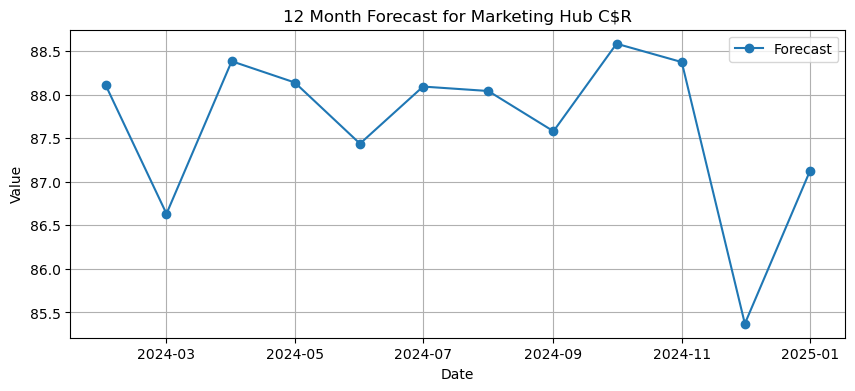

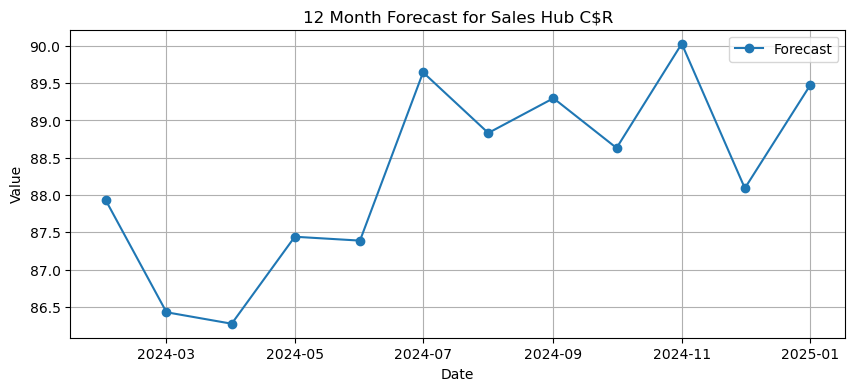

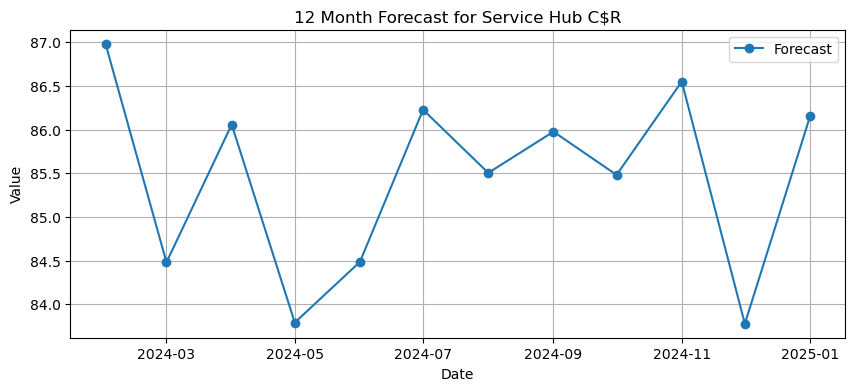

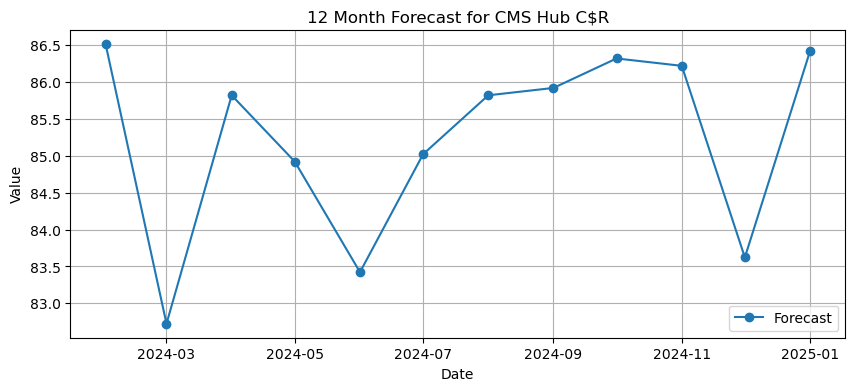

In [28]:
# Create a date range for the next 12 months starting after the last month in df_hub
start = df_hub.index[-1] + pd.offsets.MonthBegin(1)
dates = pd.date_range(start=start, periods=12, freq='MS')

# Plot the forecasts for each hub
for hub, forecast in forecasts.items():
    plt.figure(figsize=(10, 4))
    plt.plot(dates, forecast, marker='o', label='Forecast')
    plt.title(f"12 Month Forecast for {hub}")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

### PORTAL AGE ###

In [29]:
df_age = pd.read_csv("Monthly_C$R_by_Portal Age.csv")
df_age.head(5) 

,Month,<=12,13-24 months,25-36 months,37+ months,Unknown
0,2024-01,82.6%,85.1%,85.7%,90.8%,100.0%
1,2023-12,81.7%,83.5%,84.9%,88.7%,66.4%
2,2023-11,84.4%,85.5%,87.8%,91.8%,52.9%
3,2023-10,81.4%,86.3%,86.8%,91.4%,0.0%
4,2023-09,81.7%,84.6%,87.7%,91.0%,100.0%


In [30]:

df_age['Month'] = pd.to_datetime(df_age['Month'])
df_age['<=12'] = df_age['<=12'].str.rstrip('%').astype('float') 
df_age['13-24 months'] = df_age['13-24 months'].str.rstrip('%').astype('float') 
df_age['25-36 months'] = df_age['25-36 months'].str.rstrip('%').astype('float') 
df_age['37+ months'] = df_age['37+ months'].str.rstrip('%').astype('float') 
df_age.index = df_age['Month']

# Ensure the frequency is set, e.g., 'MS' for month start if it's monthly data
# This is crucial for ARIMA models as they are sensitive to the frequency of the data
df_age = df_age.asfreq('MS')


In [ ]:
# Prepare a dictionary to hold forecasts
forecasts_age = {}

# List of columns to forecast
columns_to_forecast_age = ['<=12', '13-24 months', '25-36 months', '37+ months']

# Loop over the columns and create forecasts
for column in columns_to_forecast_age:
    # Assuming non-seasonal order of (1, 1, 1) and seasonal order of (1, 1, 1, 12)
    # You can adjust these orders based on the column's data or use auto_arima to find optimal parameters
    sarima_model_age = auto_arima(df_age[column], start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=1, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

    # Forecast the next 12 months
    forecast_age = sarima_model_age.predict(n_periods=12)
    forecasts_age [column] = forecast_age

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=174.852, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=162.372, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=171.726, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=163.635, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=163.628, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=163.804, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=163.657, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=163.772, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=161.778, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=169.526, Time=0.01 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=162.99

In [ ]:
# Print the forecasts for each column
for age, forecast_age in forecasts_age.items():
    print(f"Forecast for {age}:")
    print(forecast_age)
    print()  # Print a new line for better readability

# Work in Progress

### GEO ###

### SERVICE MODEL ###